In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, roc_auc_score

In [2]:
df = pd.read_csv('./dados/cleaned_dataset.csv')
df.head()

,Id,Score,State,Gender,Age,Assets,Balance,Products,HasCreditCard,Active,Income,Churned
0,1,619,1,0,42,2,5.000000e+06,1,1,1,5.677945e+09,1
1,2,608,2,0,41,1,8.380786e+06,1,0,1,4.994492e+09,0
2,3,502,1,0,42,8,5.035971e+06,3,1,0,6.846056e+09,1
3,4,699,1,0,39,1,5.071942e+06,2,0,0,8.348547e+09,0
4,5,850,2,0,43,2,1.255108e+07,1,1,1,1.122588e+10,0


In [3]:
df.isnull().sum()

Id               0
Score            0
State            0
Gender           0
Age              0
Assets           0
Balance          0
Products         0
HasCreditCard    0
Active           0
Income           0
Churned          0
dtype: int64

In [4]:
df.isna().sum()

Id               0
Score            0
State            0
Gender           0
Age              0
Assets           0
Balance          0
Products         0
HasCreditCard    0
Active           0
Income           0
Churned          0
dtype: int64

In [5]:
df = df.drop(columns=['Id'])

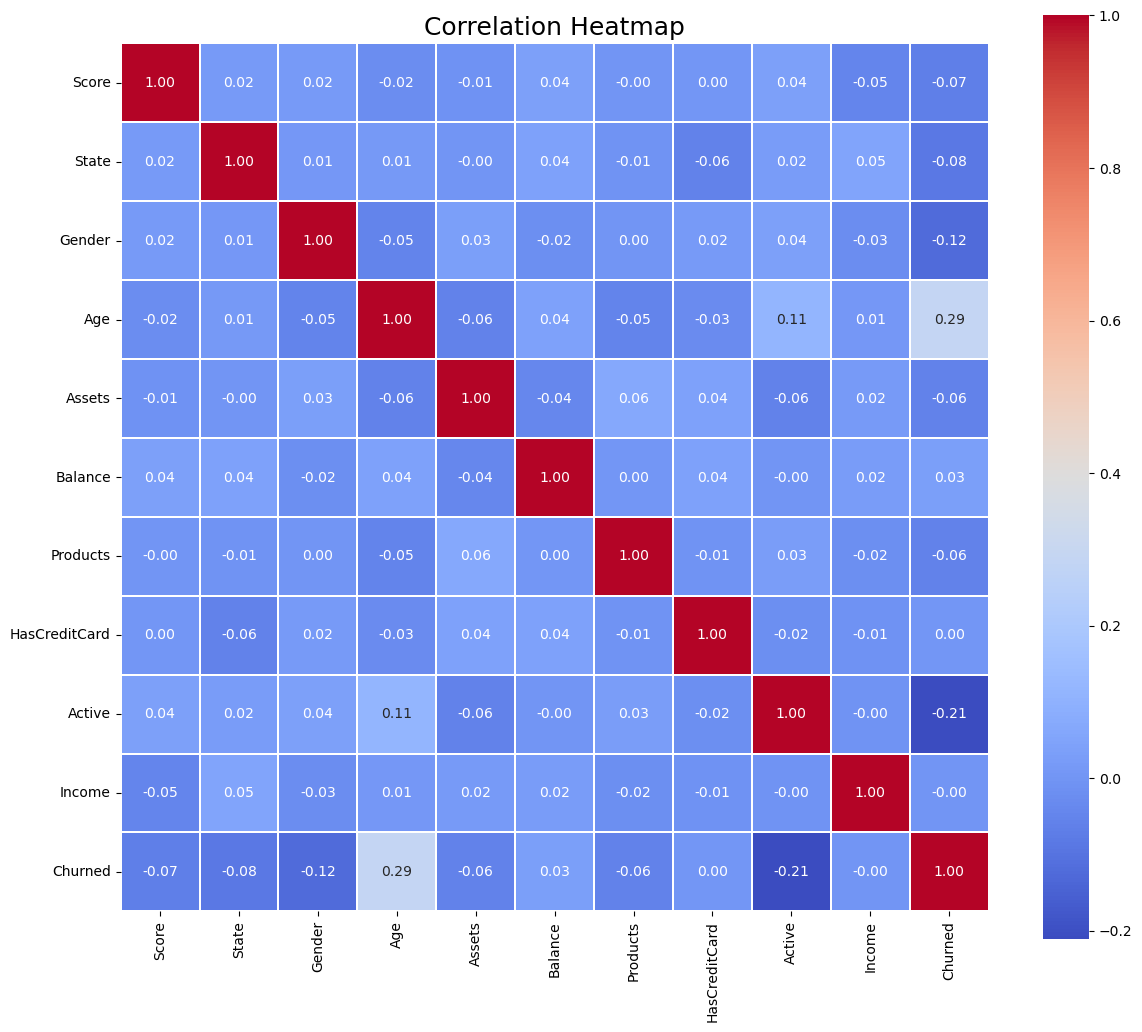

In [6]:
# Displaying a larger heatmap for better visualization of data correlation
plt.figure(figsize=(14, 12))
sns.heatmap(df.corr(), cmap='coolwarm', fmt='.2f', linewidths=0.1, vmax=1.0, square=True, linecolor='white', annot=True)
plt.title('Correlation Heatmap', fontsize=18)
plt.show()

In [7]:
formula = 'Churned ~ Active + Products + Assets + Age + Gender + State + Score'
model = smf.glm(formula=formula, data=df, family=sm.families.Binomial()).fit()
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                Churned   No. Observations:                  999
Model:                            GLM   Df Residuals:                      991
Model Family:                Binomial   Df Model:                            7
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -417.23
Date:                Sat, 23 Nov 2024   Deviance:                       834.47
Time:                        11:59:32   Pearson chi2:                     974.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1600
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.0113      0.737     -2.731      0.0

<Axes: >

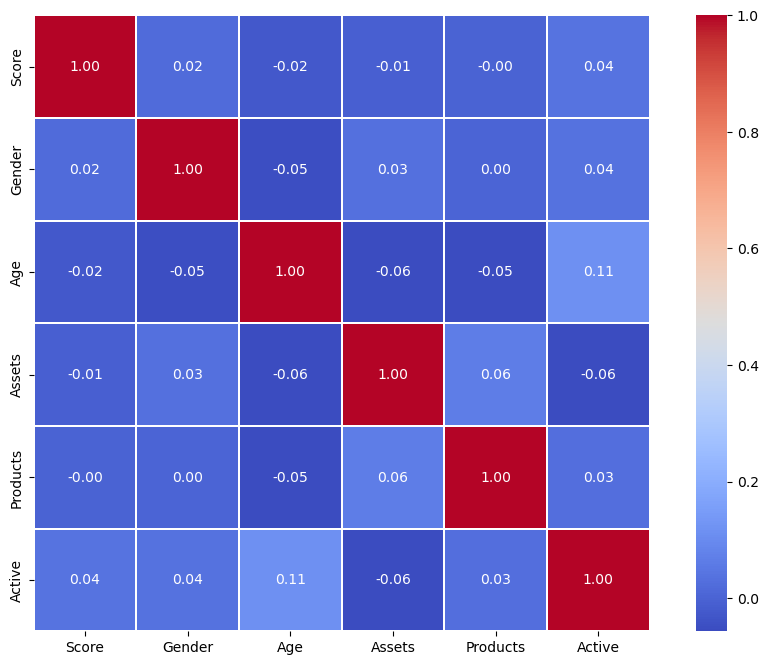

In [8]:
variables = df[['Score', 'Gender', 'Age', 'Assets', 'Products', 'Active']]
correlations = variables.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlations, cmap='coolwarm', fmt='.2f', linewidths=0.1, vmax=1.0, square=True, linecolor='white', annot=True)

In [9]:
vif = add_constant(variables)
pd.Series([variance_inflation_factor(vif.values, j) for j in range(vif.shape[1])], index=vif.columns)

const       72.906689
Score        1.002698
Gender       1.005979
Age          1.022296
Assets       1.011104
Products     1.008174
Active       1.020874
dtype: float64

### Odds ratio

In [10]:
coef = model.params
odds_ratio = np.exp(coef)
print('Odds_ratio:', odds_ratio)

Odds_ratio: Intercept    0.133809
Active       0.221280
Products     0.864515
Assets       0.952832
Age          1.083354
Gender       0.577565
State        0.722722
Score        0.998481
dtype: float64


In [11]:
X = df[['Score', 'Gender', 'Age', 'Assets', 'Products', 'Active']]
y = df['Churned']

In [12]:
X = sm.add_constant(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
logit_model = sm.Logit(y_train, X_train)
logit_result = logit_model.fit()

Optimization terminated successfully.
         Current function value: 0.420515
         Iterations 7


In [13]:
y_pred_probs = logit_result.predict(X_test)
y_pred_probs

453    0.505031
793    0.085434
209    0.123898
309    0.177499
740    0.037195
         ...   
88     0.420667
63     0.193154
825    0.046659
620    0.174235
843    0.340241
Length: 100, dtype: float64

In [14]:
y_pred_class = (y_pred_probs > 0.4).astype(int)

In [15]:
cnf_matrix = confusion_matrix(y_test, y_pred_class)

In [16]:
print('Confusion Matrix:')
print(cnf_matrix)
print('\nAccuracy', accuracy_score(y_test, y_pred_class))

Confusion Matrix:
[[71  8]
 [14  7]]

Accuracy 0.78


In [17]:
cnf_table = pd.DataFrame(data=cnf_matrix, index=['Non-Churned', 'Churned'], columns=['Non_churned(pred)', 'Churned(pred)'])

In [18]:
print(cnf_table)

             Non_churned(pred)  Churned(pred)
Non-Churned                 71              8
Churned                     14              7


In [19]:
print(classification_report(y_test, y_pred_class, target_names=['Non Churned', 'Churned']))

              precision    recall  f1-score   support

 Non Churned       0.84      0.90      0.87        79
     Churned       0.47      0.33      0.39        21

    accuracy                           0.78       100
   macro avg       0.65      0.62      0.63       100
weighted avg       0.76      0.78      0.77       100



In [20]:
# Predict probabilities for the positive class
y_pred_probs = logit_result.predict(X_test)

In [21]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

In [22]:
# Calculate AUC score
auc_score = roc_auc_score(y_test, y_pred_probs)

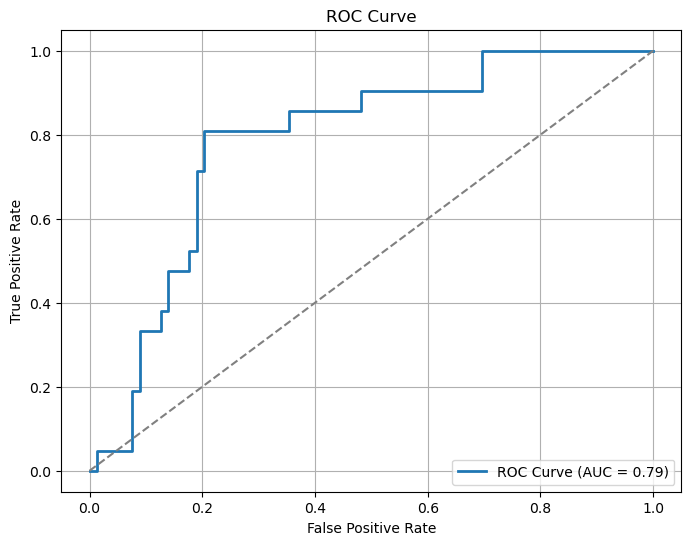

AUC Score: 0.79


In [23]:
# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})', linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Reference diagonal line
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

print(f"AUC Score: {auc_score:.2f}")